## Problem Set 3
### MACS 30100, Dr. Evans
### Leoson Hoay

**Importing necessary packages:**

In [1]:
import numpy as np
import scipy.stats as sts
import scipy.optimize as opt
import scipy.integrate as intgr
import matplotlib.pyplot as plt
import numpy.linalg as lin

### Problem (1) 
**Some income data, lognormal distribution, and GMM.**

**(a)**

<IPython.core.display.Javascript object>


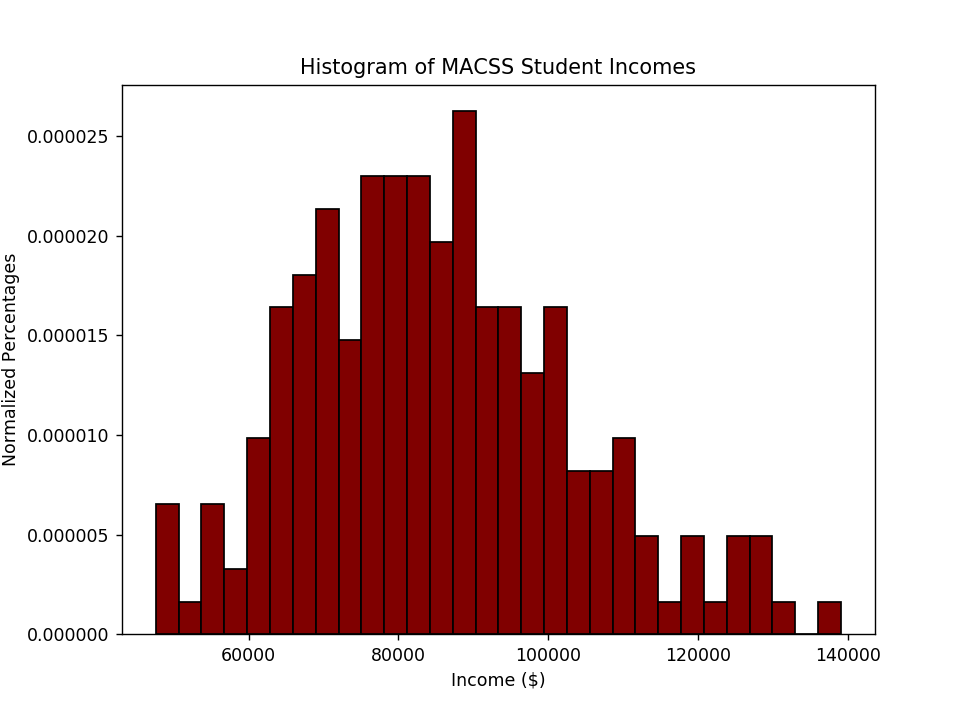

In [27]:
incomes = np.genfromtxt('../../ProblemSets/PS3/incomes.txt')

%matplotlib notebook
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = "maroon", normed=True)
plt.title('Histogram of MACSS Student Incomes')
plt.xlabel('Income (\$)')
plt.ylabel('Normalized Percentages')
plt.show()

**(b)**

In [3]:
# adapted from GMMest notebook
def trunc(xvals, mu, sigma, cutoff='None', cdf=False):
    '''
    Takes input vectors and model parameters, returns normal pdf or normal cdf values. 
    '''
    if cdf:
        if cutoff == 'None':
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.cdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    else:
        if cutoff == 'None':
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu))
        else:
            prob_notcut = sts.lognorm.cdf(cutoff, s=sigma, scale=np.exp(mu)) - sts.lognorm.cdf(0, s=sigma, scale=np.exp(mu))
            vals = sts.lognorm.pdf(xvals, s=sigma, scale=np.exp(mu)) / prob_notcut
    return vals

In [4]:
# adapted from GMMest notebook
def model_moments(mu, sigma, cutoff):
    '''
    This function computes the two model moments for GMM
    (mean(model data), variance(model data)).
    '''
    xfx = lambda x: x * trunc(x, mu, sigma, cutoff)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, cutoff)
    x2fx = lambda x: ((x - mean_model) ** 2) * trunc(x, mu, sigma, cutoff)
    (sigma_model, s_m_err) = np.sqrt(intgr.quad(x2fx, 0, cutoff))
    return mean_model, sigma_model

In [5]:
def data_moments(xvals):
    '''
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    '''
    return xvals.mean(), xvals.std()

In [6]:
# adapted from GMMest notebook
def err_vec(xvals, mu, sigma, cutoff):
    '''
    This function computes the vector of moment errors (in percent
    deviation from the data moment vector) for GMM.
    '''
    mean_model, sigma_model = model_moments(mu, sigma, cutoff)
    mean_data, sigma_data = data_moments(xvals)
    model = np.array([[mean_model], [sigma_model]])
    data = np.array([[mean_data], [sigma_data]])
    err = (model - data) / data
    
    return err

In [7]:
# define criterion function
def criterion(params, *args):
    
    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_vec(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

In [8]:
mu, sigma = 11.3, 0.21
params = np.array([mu, sigma])
W_hat = np.eye(2)
args = (incomes, 150000, W_hat)
results = opt.minimize(criterion, params, args=(args), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [9]:
mu_GMM, sig_GMM = results.x
print('mu_GMM =', mu_GMM, ' sig_GMM =', sig_GMM)
print('Value of criterion:', *criterion(results.x, *args)[0])
print('\nMean income (data) =', data_moments(incomes)[0], ', SD (data) =', data_moments(incomes)[1])
model = model_moments(mu_GMM, sig_GMM, 150000)
print('Mean income (model) =', model[0], ', SD (model) =', model[1])

mu_GMM = 11.333599880835951  sig_GMM = 0.21325525843455934
Value of criterion: 6.792265553695714e-14

Mean income (data) = 85276.82360625811 , SD (data) = 17992.542128046523
Mean income (model) = 85276.84577707565 , SD (model) = 17992.54245475267


**The data moments and model moments appear to be relatively close to each other (difference < .1), which seems to indicate a strong estimate.**

<IPython.core.display.Javascript object>


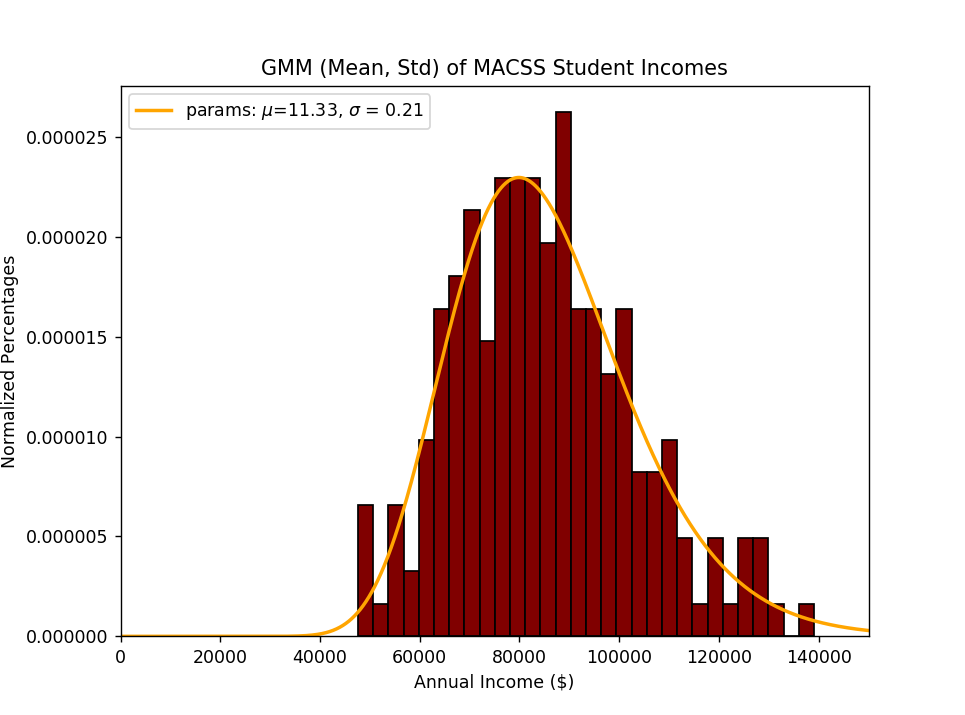

In [28]:
# plot histogram

%matplotlib notebook
fig_2 = plt.figure()
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = 'maroon', normed=True)
plt.title('GMM (Mean, Std) of MACSS Student Incomes')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Normalized Percentages')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc(dist_pts, mu_GMM, sig_GMM, cutoff = 150000),
     linewidth=2, color='orange', label=f'params: $\mu$={round(mu_GMM,2)}, $\sigma$ = {round(sig_GMM,2)}')
plt.legend(loc='upper left')

**(c)**

In [11]:
# utilize same functions as above
err = err_vec(incomes, mu_GMM, sig_GMM, cutoff=150000)
Omega = err @ err.T / incomes.shape[0]
W_hat2 = lin.pinv(Omega) 
args2 = (incomes, 150000, W_hat2)
results2 = opt.minimize(criterion, results.x, args=(args2), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM2, sig_GMM2 = results2.x

In [12]:
print('mu_GMM =', mu_GMM2, ' sig_GMM =', sig_GMM2)
print('Value of criterion:', *criterion(results2.x, *args2)[0])
print('\nMean income (data) =', data_moments(incomes)[0], ', SD (data) =', data_moments(incomes)[1])
model2 = model_moments(mu_GMM2, sig_GMM2, 150000)
print('Mean income (model: two-step) =', model2[0], ', SD (model: two-step) =', model2[1])

mu_GMM = 11.33359948902157  sig_GMM = 0.21325560222123596
Value of criterion: 1.0660536867764664e-08

Mean income (data) = 85276.82360625811 , SD (data) = 17992.542128046523
Mean income (model: two-step) = 85276.81657773622 , SD (model: two-step) = 17992.563360558543


**Once again, the data moments and model moments appear to be relatively close to each other (difference < .1), which seems to indicate a strong estimate. However, the two-step model gives a closer estimate for the mean, but a less precise estimate for the standard deviation as compared to (b) : (Mean = 85276.84577707565. SD = 17992.54245475267).**

<IPython.core.display.Javascript object>


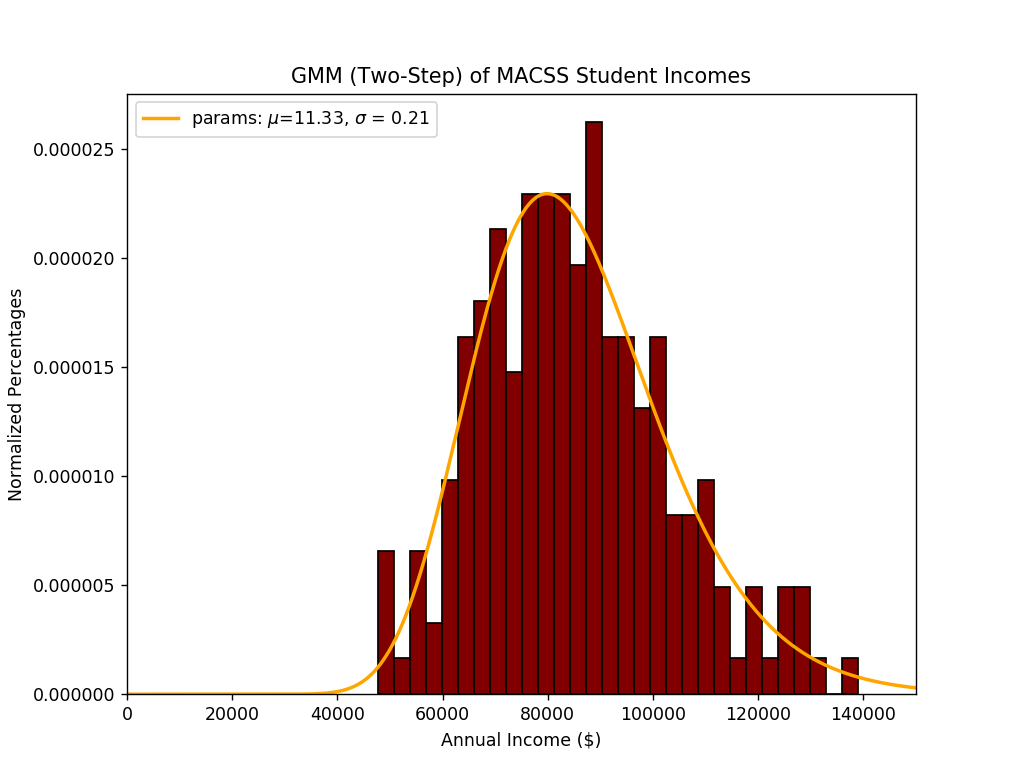

In [29]:
# plot histogram
%matplotlib notebook
fig_3 = plt.figure()
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = 'maroon', normed=True)
plt.title('GMM (Two-Step) of MACSS Student Incomes')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Normalized Percentages')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc(dist_pts, mu_GMM2, sig_GMM2, cutoff = 150000),
     linewidth=2, color='orange', label=f'params: $\mu$={round(mu_GMM2,2)}, $\sigma$ = {round(sig_GMM2,2)}')
plt.legend(loc='upper left')

**(d)**

In [14]:
# define new moment functions
def data_moments_d(xvals):
    
    m1 = len(xvals[xvals < 75000]) / len(xvals)
    m3 = len(xvals[xvals > 100000]) / len(xvals)
    m2 = 1 - m1 - m3
    
    return m1, m2, m3

def model_moments_d(mu, sigma, cutoff):
    
    m1 = trunc(75000, mu, sigma, cutoff, cdf=True)
    m2 = trunc(100000, mu, sigma, cutoff, cdf=True) - m1
    m3 = 1 - m2 - m1
    
    return m1, m2, m3

In [15]:
# define new error function
def err_2(xvals, mu, sigma, cutoff):

    m1_model, m2_model, m3_model = model_moments_d(mu, sigma, cutoff)
    m1_data, m2_data, m3_data = data_moments_d(xvals)
    model = np.array([[m1_model], [m2_model], [m3_model]])
    data = np.array([[m1_data], [m2_data], [m3_data]])
    err = (model - data) / data
    
    return err

In [16]:
# define new criterion function
def criterion2(params, *args):

    mu, sigma = params
    xvals, cutoff, W = args
    err_v = err_2(xvals, mu, sigma, cutoff)
    crit_val = err_v.T @ W @ err_v
    
    return crit_val

In [17]:
mu3, sigma3 = 11.3, 0.212
params3 = np.array([mu3, sigma3])
W_hat3 = np.eye(3)
args3 = (incomes, 'None', W_hat3)
results3 = opt.minimize(criterion2, params3, args=(args3), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))

In [18]:
mu_GMM3, sig_GMM3 = results3.x
data3 = data_moments_d(incomes)
model3 = model_moments_d(mu_GMM3, sig_GMM3, 'None')
print('mu_GMM =', mu_GMM3, ' sig_GMM =', sig_GMM3)
print('Value of criterion:', (*criterion2(results3.x, *args3)[0]))
print('\nMoments(data):', (round(data3[0], 1)), (round(data3[1], 1)), (round(data3[2], 1)))
print('Moments(model):', *model3)

mu_GMM = 11.335681317533936  sig_GMM = 0.21059845987737247
Value of criterion: 1.3671759059587945e-14

Moments(data): 0.3 0.5 0.2
Moments(model): 0.3000000252924775 0.49999999045482046 0.19999998425270205


**Barring rounding errors, the  data moments and model moments are similar to each other. However, mu and sigma seem to have been altered more than in the previous sections.**

<IPython.core.display.Javascript object>


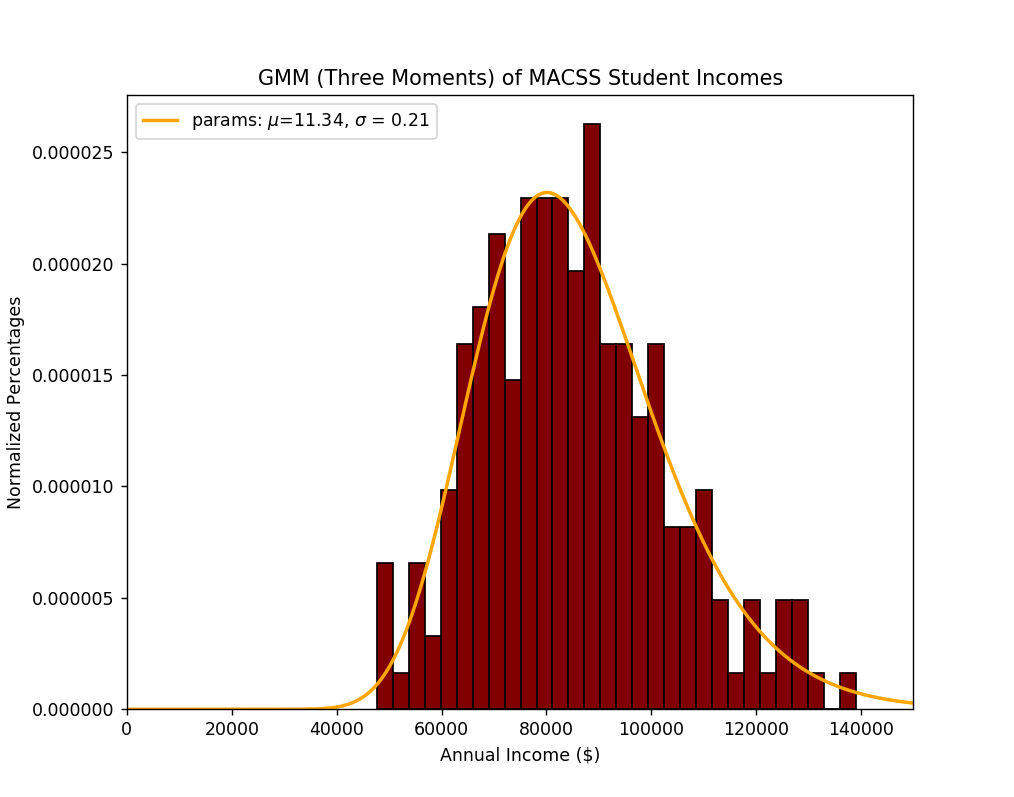

In [30]:
# plot histogram

%matplotlib notebook
fig_4 = plt.figure()
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = 'maroon', normed=True)
plt.title('GMM (Three Moments) of MACSS Student Incomes')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Normalized Percentages')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc(dist_pts, mu_GMM3, sig_GMM3, cutoff = 150000),
     linewidth=2, color='orange', label=f'params: $\mu$={round(mu_GMM3,2)}, $\sigma$ = {round(sig_GMM3,2)}')
plt.legend(loc='upper left')

**(e)**

In [20]:
err2 = err_2(incomes, mu_GMM3, sig_GMM3, cutoff=150000)
Omega2 = err2 @ err2.T / incomes.shape[0]
W_hat4 = lin.pinv(Omega2) 
args4 = (incomes, 150000, W_hat4)
results4 = opt.minimize(criterion2, results3.x, args=(args4), method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None)))
mu_GMM4, sig_GMM4 = results4.x

In [21]:
params4 = np.array([mu_GMM4, sig_GMM4])
data4 = data_moments_d(incomes)
model4 = model_moments_d(mu_GMM4, sig_GMM4, 150000)
print('mu_GMM =', mu_GMM4, ' sig_GMM =', sig_GMM4)
print('Value of criterion:', criterion2(params4, *args4)[0][0])
print('\nMoments(data):', (round(data4[0], 1)), (round(data4[1], 1)), (round(data4[2], 1)))
print('Moments(model):', *model4)

mu_GMM = 11.336798829359262  sig_GMM = 0.21137743763784617
Value of criterion: 9.142855610649949e-11

Moments(data): 0.3 0.5 0.2
Moments(model): 0.299723997145864 0.5002927331893314 0.19998326966480456


**As in (d), barring rounding errors, the data moments and model moments are similar to each other.**

<IPython.core.display.Javascript object>


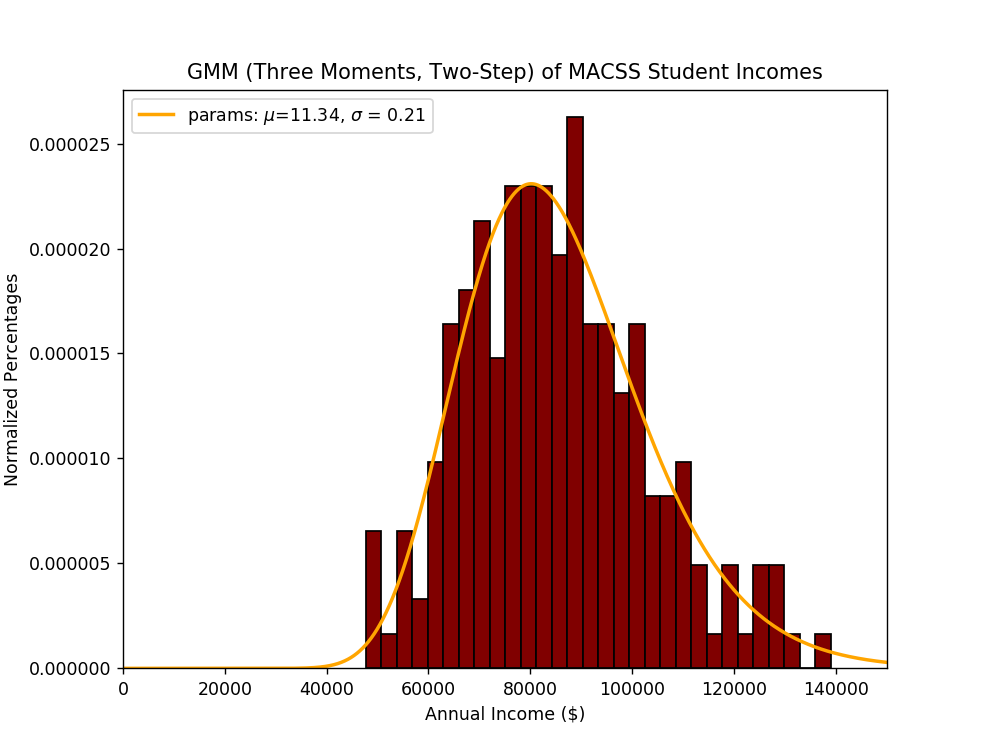

In [31]:
# plot histogram
%matplotlib notebook
fig_5 = plt.figure()
count, bins, ignored = plt.hist(incomes, 30, edgecolor='black', color = 'maroon', normed=True)
plt.title('GMM (Three Moments, Two-Step) of MACSS Student Incomes')
plt.xlabel(r'Annual Income (\$)')
plt.ylabel(r'Normalized Percentages')
plt.xlim([0, 150000])
dist_pts = np.linspace(0, 150000, 150000)
plt.plot(dist_pts, trunc(dist_pts, mu_GMM4, sig_GMM4, cutoff = 150000),
     linewidth=2, color='orange', label=f'params: $\mu$={round(mu_GMM4,2)}, $\sigma$ = {round(sig_GMM4,2)}')
plt.legend(loc='upper left')

**(f)**

**By purely scrutinizing the criterion value, it seems that the model in (d) fits that data best. However, as was discussed in class, when choosing data moments to fit the model, the question of interest should also be considered. It may be that a model fits a moment of interest better than another, but does more poorly on a different range of the dataset. In this case, since all the models seem to provide a reasonably similar level of fit, the criterion values, alongside the minimal improvement using the two-step method points towards (d) as a good fit.**

### Problem (2) 
**Linear Regression and GMM.**

In [23]:
sick = np.loadtxt('../../ProblemSets/PS3/sick.txt', skiprows=1, delimiter=',')
len(sick)

200

**(a)**

In [24]:
# define new error function
def err_3(xvals, b0, b1, b2, b3):
    
    data = sick[:,0]
    model = b0 + b1*sick[:,1] + b2*sick[:,2] + b3*sick[:,3]
    err = data - model 
    
    return err

# define new criterion function
def criterion3(params, *args):
    
    b0, b1, b2, b3 = params
    xvals, W = args
    err = err_3(xvals, *params)
    crit_val = err.T @ W @ err
    
    return crit_val

In [25]:
#initialize parameters
params5 = np.array([0, 0, 0, 0]) 
W_hat5 = np.eye(200) # observations as moments
args5 = (sick, W_hat5)
#initialize results of minimization
results5 = opt.minimize(criterion3, params5, args=(args5), method = 'L-BFGS-B')
b0, b1, b2, b3 = results5.x

In [26]:
criterion_reg = criterion3(results5.x, *args5)
print('b0 =', b0)
print('b1 =', b1)
print('b2 =', b2)
print('b3 =', b3)
print('\nValue of criterion:', criterion_reg)

b0 = 0.25164519145957487
b1 = 0.012933537644642354
b2 = 0.40050047555465845
b3 = -0.00999175895654694

Value of criterion: 0.001821289793249796


**We observe that the moments employed here are the observations within the dataset.**